## Initialize notebook

###Setting the data path

In [1]:
# data_path = '/content/learning_to_simulate/datasets/WaterDropSample/'
# data_path = '/content/drive/MyDrive/Dissertation/learning_to_simulate'
# data_path = '/content/drive/MyDrive/Dissertation/learning_to_simulate/datasets/WaterDrop100'
# data_path = '/content/drive/MyDrive/Dissertation/learning_to_simulate/datasets/WaterDropFull'
data_path_partitioned = '/content/drive/MyDrive/Dissertation/learning_to_simulate/datasets/WaterDropPartitioned'

###dos2unix installation command

In [2]:
!sudo apt install dos2unix

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  dos2unix
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 384 kB of archives.
After this operation, 1,367 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 dos2unix amd64 7.4.2-2 [384 kB]
Fetched 384 kB in 1s (271 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package dos2unix.
(Reading database ... 120875 files and directories curren

###downloading datasets

In [ ]:
# !mkdir -p /content/learning_to_simulate/datasets
# !dos2unix -b ./learning_to_simulate/download_dataset.sh
# !bash ./learning_to_simulate/download_dataset.sh WaterDropSample /content/learning_to_simulate/datasets

dos2unix: converting file ./learning_to_simulate/download_dataset.sh to Unix format...
--2023-10-12 02:42:58--  https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/WaterDropSample/metadata.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 209.85.200.207, 209.85.234.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 365 [application/octet-stream]
Saving to: ‘/content/learning_to_simulate/datasets/WaterDropSample/metadata.json’

/content/learning_t 100%[===================>]     365  --.-KB/s    in 0s      

2023-10-12 02:42:58 (275 MB/s) - ‘/content/learning_to_simulate/datasets/WaterDropSample/metadata.json’ saved [365/365]

--2023-10-12 02:42:58--  https://storage.googleapis.com/learning-to-simulate-complex-physics/Datasets/WaterDropSample/train.tfrecord
Resolving storage.googleapis.com (storage.googleapis.com)... 142.2

###Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a folder in the root directory
# !mkdir -p "/content/drive/MyDrive/Dissertation/learning_to_simulate/"

In [ ]:
# import sys
# sys.path.append('/content/drive/MyDrive/Dissertation/')

###parsing data from TFRecordDataset into .dat and .json files for training and evaluation

In [ ]:
import os
import json
import argparse
import functools

import numpy as np
import tensorflow as tf
from learning_to_simulate import reading_utils


def main():
    # parser = argparse.ArgumentParser()
    # parser.add_argument("data_path")
    # args = parser.parse_args()

    with open(os.path.join(data_path_partitioned, "metadata.json")) as f:
        metadata = json.load(f)

    for split in ["train", "valid", "test"]:
        ds = tf.data.TFRecordDataset([os.path.join(data_path_partitioned, f"{split}.tfrecord")])
        ds = ds.map(functools.partial(
            reading_utils.parse_serialized_simulation_example, metadata=metadata))
        data_shape = {}
        file_offset = {}
        sample_count = 0
        if split == "train":
          data_partition = 200
        else:
          data_partition = 30

        for sample in ds.as_numpy_iterator():
          context, parsed_features = sample
          data = {"particle_type": context["particle_type"], **parsed_features}
          shape = {}
          for key, value in data.items():
              filename = os.path.join(data_path_partitioned, split + f"_{data_partition}" + "_" + key + ".dat")
              offset = file_offset.get(key, 0)
              if key == "particle_type":
                  assert value.dtype == np.int64, value.dtype
              else:
                  assert value.dtype == np.float32, value.dtype
              mode = "r+" if os.path.exists(filename) else "w+"
              array = np.memmap(filename, dtype=value.dtype, mode=mode, offset=offset * value.dtype.itemsize, shape=value.shape)
              array[:] = value
              shape[key] = {"offset": offset, "shape": value.shape}
              file_offset[key] = offset + value.size
          data_shape[int(context["key"])] = shape
          sample_count += 1

          if sample_count == data_partition:
            with open(os.path.join(data_path_partitioned, split + f"_{data_partition}" + "_offset.json"), "w") as f:
                json.dump(data_shape, f, indent=2)
            data_shape = {}
            file_offset = {}
            if split == "train":
              data_partition += 200



if __name__ == "__main__":
    main()

example_proto: Tensor("args_0:0", shape=(), dtype=string)
example_proto: Tensor("args_0:0", shape=(), dtype=string)
example_proto: Tensor("args_0:0", shape=(), dtype=string)


### DGL installation and PyTorch import

In [4]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
# !pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 MB 9.6 MB/s eta 0:00:00


In [5]:
import dgl

dgl.__version__

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


'1.1.2+cu118'

In [6]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.0.1+cu118 with cuda 11.8


##Data-Preprocessing

###Creation and Visuzlization helper functions for Hierarchical Graph between particles and cluster centers
Visualize as a homogeneous graph for intuition

In [7]:
def create_hierarchical_graph(labels, rec_position, kmeans, return_graph=False):
      #generate node_ids for kmeans.labels_
      label_node_id_mapper = lambda lbls, pos: [items + pos.size(0) for items in labels]
      label_nodes_with_ids = label_node_id_mapper(labels, rec_position)

      positions = torch.cat((rec_position, torch.from_numpy(kmeans.cluster_centers_)), dim = 0)

      #generate edge indices for homogeneous graph visualization
      edge_index = [(index, int(item))for index, item in enumerate(label_nodes_with_ids)]

      unzipped_list = list(zip(*edge_index))
      src_node_ids = unzipped_list[0]
      dst_node_ids = unzipped_list[1]

      edges = (src_node_ids, dst_node_ids)
      hier_graph = dgl.graph((src_node_ids, dst_node_ids))

      #create edge inidces for heterogeneous graph edge_types
      het_edge_index = [(index, int(item))for index, item in enumerate(labels)]
      unzipped_list_het = list(zip(*het_edge_index))
      src_node_ids_het = unzipped_list_het[0]
      dst_node_ids_het = unzipped_list_het[1]

      if return_graph is False:
        return src_node_ids_het, dst_node_ids_het, None, None
      return src_node_ids_het, dst_node_ids_het, hier_graph, positions

def create_radius_graph_for_cluster_centers(recent_position, centers, return_graph=False):
      #create radius graph for cluster centers
      cluster_centers_radius_graph = dgl.radius_graph(centers, 0.020, self_loop = True)
      cluster_edges = cluster_centers_radius_graph.edges()
      radius_graph_for_cluster_centers = dgl.graph((cluster_edges[0], cluster_edges[1]), num_nodes=int(len(recent_position)/3))

      #generate edge features
      dim = recent_position.size(-1)
      edge_displacement = (torch.gather(centers, dim=0, index=cluster_edges[0].unsqueeze(-1).expand(-1, dim)) -
                    torch.gather(centers, dim=0, index=cluster_edges[1].unsqueeze(-1).expand(-1, dim)))
      edge_displacement /= 0.020
      edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)
      cluster_graph_edge_feat = torch.cat((edge_displacement, edge_distance), dim=-1)

      if return_graph is False:
        return cluster_edges, cluster_graph_edge_feat, None, None
      return cluster_edges, cluster_graph_edge_feat, radius_graph_for_cluster_centers, centers

def create_visualize_hierarchical_graphs(labels, recent_position, kmeans, centers, visualize_hierarchy=False):
  src_node_ids_het, dst_node_ids_het, hier_graph, positions = create_hierarchical_graph(labels, recent_position, kmeans, return_graph=visualize_hierarchy)
  cluster_edges, cluster_graph_edge_feat, radius_graph_for_cluster_centers, centers = create_radius_graph_for_cluster_centers(recent_position, centers, return_graph=visualize_hierarchy)
  return src_node_ids_het, dst_node_ids_het, hier_graph, positions, cluster_edges, cluster_graph_edge_feat, radius_graph_for_cluster_centers, centers

### Full Heterograph creation

In [8]:
import json
import numpy as np
from sklearn.cluster import KMeans


def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise

def gen_cluster_center_edge_feat(kmeans, recent_positions):
    la = []
    for item in kmeans.labels_:
      cc= kmeans.cluster_centers_[item]
      la.append(cc)
    par_cen_zip = list(zip(recent_positions, torch.Tensor(np.array(la))))

    disp_list = []
    for item in par_cen_zip :
      displacement = item[1] - item[0]
      displacement /= 0.015
      distance = torch.norm(displacement, dim=-1, keepdim=True)
      disp_list.append(torch.cat((displacement, distance), dim=-1))
    return torch.stack(disp_list, dim=0)

def visualize(recent_position, kmeans):
    p_cc_positions = []
    x_pos = []
    y_pos = []
    for item in recent_position:
      x_pos.append(item[0])
      y_pos.append(item[1])

    c_x_pos = []
    c_y_pos = []
    for centers in kmeans.cluster_centers_:
      c_x_pos.append(centers[0])
      c_y_pos.append(centers[1])

    p_cc_positions = ((x_pos, y_pos), (c_x_pos, c_y_pos))
    return p_cc_positions, kmeans.labels_

def preprocess(particle_type, position_seq, target_position, metadata, noise_std, visualize_hierarchy=False):
    """Preprocess a trajectory and construct the graph"""
    #################################################################################################################################################
    ################################################PARTICLE-GRAPH PREPROCESSING PART################################################################
    #################################################################################################################################################

    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)

    # Each node has neighbors within default_connectivity_radius distance
    r_g = dgl.radius_graph(recent_position, metadata["default_connectivity_radius"], self_loop = True)
    edge_index = r_g.edges()

    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    #################################################################################################################################################
    ################################################HIERARCHICAL-GRAPH PREPROCESSING PART############################################################
    #################################################################################################################################################

    #Use K-Means clustering into groups of 3 particle-nodes
    num_clusters = (int(len(recent_position)/3))
    kmeans = KMeans(n_init='auto',n_clusters=num_clusters)
    kmeans.fit(recent_position)

    p_cc_positions = []
    if visualize_hierarchy:
      p_cc_positions, kmeans_cluster_labels = visualize(recent_position,kmeans)

    # create list with particle positions and cluster center positions:
    labels = torch.from_numpy(kmeans.labels_)
    centers = torch.from_numpy(kmeans.cluster_centers_)
    zipped_pos_labels = list(zip(recent_position, labels))
    src_het, dst_het, hier_graph, positions, cluster_edges, cluster_graph_edge_feat, radius_graph_for_cluster_centers, centers = create_visualize_hierarchical_graphs(labels, recent_position, kmeans, centers, visualize_hierarchy)

    # heterograph creation
    graph_data_dict = {
          ('particle_node', 'p_p_interaction', 'particle_node'): (edge_index[0], edge_index[1]), # particle-particle radius graph (Leaf-Leaf)
          ('particle_node', 'p_cc_send', 'cluster_center_node'): (src_het, dst_het),             # particle-cluster_center graph (Leaf-Root)
          ('cluster_center_node', 'cc_cc_interaction', 'cluster_center_node'): (cluster_edges),  # cluster_center-cluster_center graph (Root-Root)
          ('cluster_center_node', 'cc_p_send', 'particle_node'): (dst_het, src_het)              # cluster_center-particle graph (Root-Leaf)
        }
    # num_nodes_dict = {'particle_node': 482, 'cluster_center_node': 8}
    heterograph = dgl.heterograph(graph_data_dict)

    #generate cluster center edge feat
    c_edge_feat = gen_cluster_center_edge_feat(kmeans, recent_position)

    #assign node data in heterograph
    #particle_node
    heterograph.nodes['particle_node'].data['node_pos_feat_14d'] = torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    heterograph.nodes['particle_node'].data['node_particle_type'] = particle_type
    if acceleration is not None:
      heterograph.nodes['particle_node'].data['nodetarget_2d_acceleration'] = acceleration

    #cluster_center_node
    #initialize cluster_center_node_features to 0(zero). After Leaf-Root propagation, they will have information as messages will be aggregated from particles in the cluster
    cluster_center_node_features = torch.zeros([num_clusters, 128])
    heterograph.nodes['cluster_center_node'].data['node_feat'] = cluster_center_node_features

    #assign edge data in heterograph
    heterograph.edges[('particle_node', 'p_p_interaction', 'particle_node')].data['edgefeature_3d'] = torch.cat((edge_displacement, edge_distance), dim=-1)
    heterograph.edges[('particle_node', 'p_cc_send', 'cluster_center_node')].data['edge_feat'] = c_edge_feat
    heterograph.edges[('cluster_center_node', 'cc_cc_interaction', 'cluster_center_node')].data['edge_feat'] = cluster_graph_edge_feat.to(torch.float32)
    heterograph.edges[('cluster_center_node', 'cc_p_send', 'particle_node')].data['edge_feat'] = c_edge_feat

    if visualize_hierarchy:
      return heterograph, p_cc_positions, kmeans_cluster_labels, hier_graph, positions, radius_graph_for_cluster_centers, centers
    return heterograph

###One-Step Dataset
(inherits from dgl.data.Dataset base-class)

For generating graph datasets. This class generates 995 One-Step datasets for each trajectory. Each trajectory is 1000 frames.

In [9]:
import pandas as pd

class OneStepDataset(dgl.data.DGLDataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False, visualize_hierarchy=False):
        self.visualize_hierarchy=visualize_hierarchy
        self.data_path = data_path
        self.split = split
        self.window_length = window_length
        self.noise_std = noise_std
        self.return_pos = return_pos
        super().__init__(name="OneStepDataset")


    def download(self):
      with open(os.path.join(self.data_path, "metadata.json")) as f:
          self.metadata = json.load(f)
      with open(os.path.join(self.data_path, f"{self.split}_offset.json")) as f:
          self.offset = json.load(f)
      self.particle_type = np.memmap(os.path.join(self.data_path, f"{self.split}_particle_type.dat"), dtype=np.int64, mode="r")
      self.position = np.memmap(os.path.join(self.data_path, f"{self.split}_position.dat"), dtype=np.float32, mode="r")

    def process(self):
        self.offset = {int(k): v for k, v in self.offset.items()}
        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in self.offset.values():
            size = traj["position"]["shape"][1]
            length = traj["position"]["shape"][0] - self.window_length + 1
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"]["offset"],
                    "pos": traj["position"]["offset"] + i * size * self.dim,
                }
                self.windows.append(desc)


    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        size = window["size"]
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position_seq = self.position[window["pos"]: window["pos"] + self.window_length * size * self.dim].copy()
        position_seq.resize(self.window_length, size, self.dim)
        position_seq = position_seq.transpose(1, 0, 2)
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]
        target_position = torch.from_numpy(target_position)
        position_seq = torch.from_numpy(position_seq)
        # construct the graph
        with torch.no_grad():
          if self.visualize_hierarchy:
            graph, p_cc_positions, kmeans_cluster_labels, hier_graph, positions, radius_graph_for_cluster_centers, centers = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std, self.visualize_hierarchy)
            return graph, p_cc_positions, kmeans_cluster_labels, hier_graph, positions, radius_graph_for_cluster_centers, centers, position_seq[:, -1]
          else:
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std, self.visualize_hierarchy)
            return graph

###Rollout Dataset

In [10]:
class RolloutDataset(dgl.data.DGLDataset):
    def __init__(self, data_path, split, window_length=7):
        self.data_path = data_path
        self.split = split
        self.window_length = window_length
        self.windows = []
        super().__init__(name="RolloutDataset")

    def download(self):
        with open(os.path.join(self.data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        with open(os.path.join(self.data_path, f"{self.split}_offset.json")) as f:
            self.offset = json.load(f)

        self.particle_type = np.memmap(os.path.join(self.data_path, f"{self.split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.position = np.memmap(os.path.join(self.data_path, f"{self.split}_position.dat"), dtype=np.float32, mode="r")


    def process(self):
        self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = self.window_length

        for traj in self.offset.values():
            self.dim = traj["position"]["shape"][2]
            break

    def __len__(self):
        return len(self.offset)

    def __getitem__(self, idx):
        traj = self.offset[idx]
        size = traj["position"]["shape"][1]
        time_step = traj["position"]["shape"][0]
        particle_type = self.particle_type[traj["particle_type"]["offset"]: traj["particle_type"]["offset"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position = self.position[traj["position"]["offset"]: traj["position"]["offset"] + time_step * size * self.dim].copy()
        position.resize(traj["position"]["shape"])
        position = torch.from_numpy(position)
        data = {"particle_type": particle_type, "position": position}
        return data

###Visualization a graph from the dataset

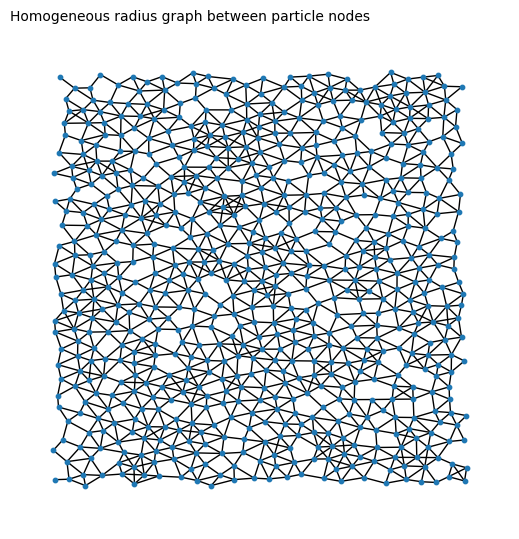

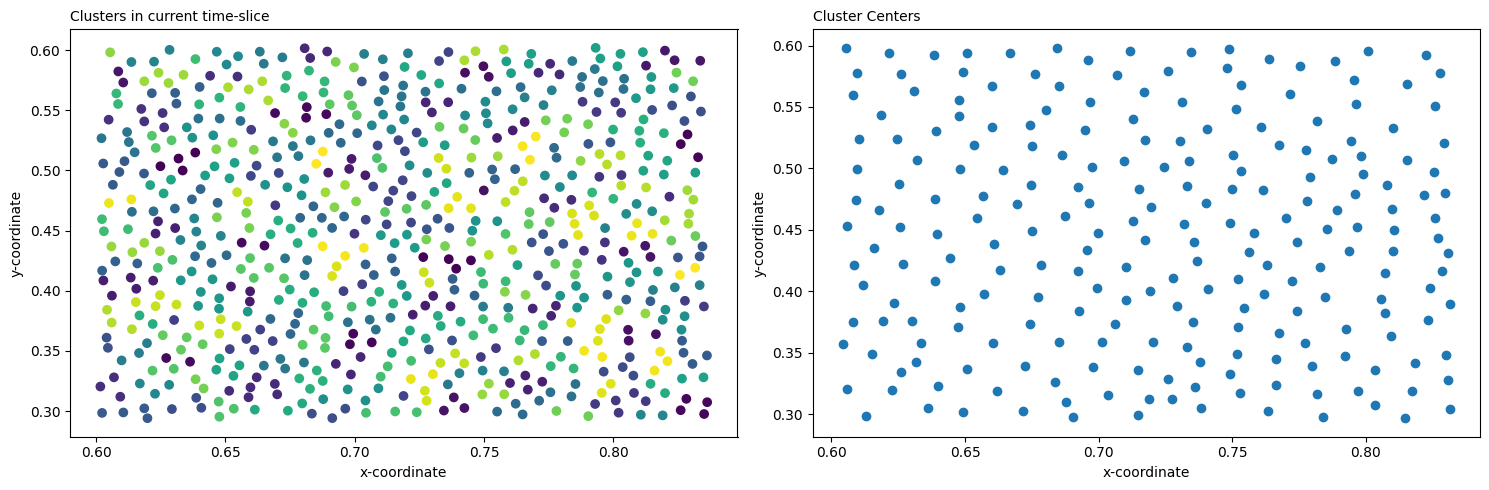

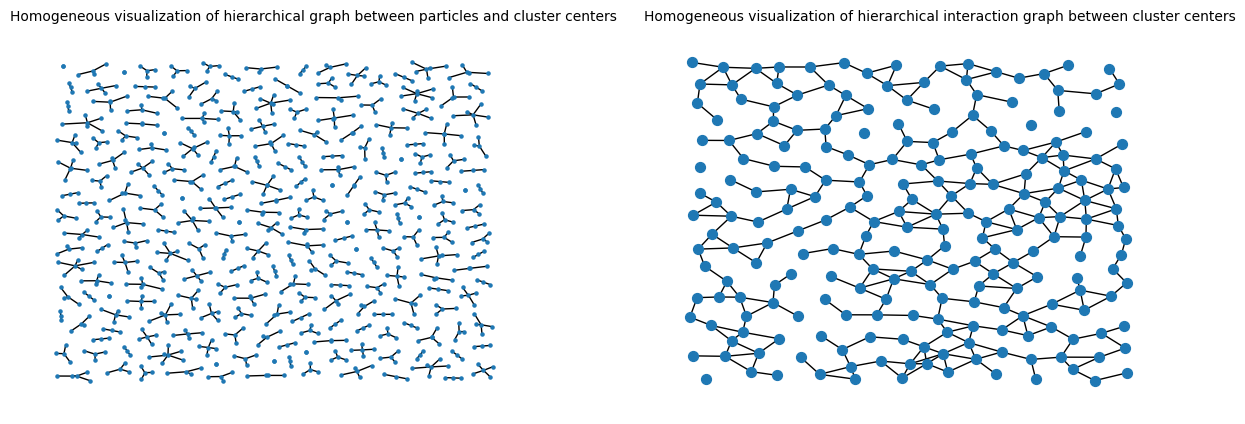

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
OUTPUT_DIR = '/content/drive/MyDrive/Dissertation/learning_to_simulate/datasets/WaterDropPartitioned'
dataset_sample = OneStepDataset(OUTPUT_DIR,"train_200", visualize_hierarchy=True)
# rdataset_sample = RolloutDataset(OUTPUT_DIR,"valid")

graph, p_cc_positions, kmeans_cluster_labels, hier_graph, positions, radius_graph_for_cluster_centers, centers, position = dataset_sample[0]
#visualize homogeneous graph
edge_index = graph.edges(etype='p_p_interaction')
homo_graph = dgl.graph(edge_index)
G = dgl.to_networkx(homo_graph.cpu()).to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(5, 5))
nx.draw(G, pos={i: tuple(v) for i, v in enumerate(position)}, node_size=10)
plt.title('Homogeneous radius graph between particle nodes', fontsize= 10, loc='left')
plt.show()

# Section for plotting K-means clustering of particles w.r.t their current time-slice position(noise added)
fig_1, ax_1 = plt.subplots(figsize=(15, 5))
ax_1.remove()
plt.subplot(1, 2, 1)
x_pos = p_cc_positions[0][0]
y_pos = p_cc_positions[0][1]
plt.scatter(x_pos, y_pos, c=kmeans_cluster_labels)
plt.title('Clusters in current time-slice', fontsize= 10, loc='left')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
c_x_pos = p_cc_positions[1][0]
c_y_pos = p_cc_positions[1][1]
plt.subplot(1, 2, 2)
plt.scatter(c_x_pos, c_y_pos)
plt.title('Cluster Centers', fontsize= 10, loc='left')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.tight_layout()

# Code for plotting the graph (commented for now)
fig_2, ax_2 = plt.subplots(figsize=(15, 5))
ax_2.remove()
plt.subplot(1, 2, 1)
G_hier = dgl.to_networkx(hier_graph.cpu()).to_undirected()
G_hier.remove_edges_from(nx.selfloop_edges(G_hier))
nx.draw(G_hier, pos={i: tuple(v) for i, v in enumerate(positions)}, node_size=5)
plt.title("Homogeneous visualization of hierarchical graph between particles and cluster centers", fontsize=10, loc = 'left')


# Code for plotting the graph (commented for now)
plt.subplot(1, 2, 2)
G_radius = dgl.to_networkx(radius_graph_for_cluster_centers.cpu()).to_undirected()
G_radius.remove_edges_from(nx.selfloop_edges(G_radius))
nx.draw(G_radius, pos={i: tuple(v) for i, v in enumerate(centers)}, node_size=50)
plt.title("Homogeneous visualization of hierarchical interaction graph between cluster centers", fontsize=10 ,loc = 'left')
plt.show()

## GNN Model


### Helper class

MLP

In [12]:
import math
# import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                layer.bias.data.fill_(0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Implement a single GNN layer in DGL
We call our Graph Neural Network layer a "Hierarchical Graph Network"

In [13]:
class HierarchicalGraphNetwork(torch.nn.Module):
  """Hierarchical Graph Network"""
  def __init__(self, hidden_size, layers):
    super().__init__()
    self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
    self.lin_node = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
    self.lin_edge_p_cc = MLP(hidden_size * 2, hidden_size, hidden_size, layers)
    self.lin_node_p_cc = MLP(hidden_size * 2, hidden_size, hidden_size, layers)
    self.lin_edge_cc = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
    self.lin_node_cc = MLP(hidden_size * 2, hidden_size, hidden_size, layers)
    self.lin_edge_cc_p = MLP(hidden_size * 2, hidden_size, hidden_size, layers)
    self.lin_node_cc_p = MLP(hidden_size * 2, hidden_size, hidden_size, layers)


  def forward(self, graph):
    """Forward computation:
    Generates messages between nodes having edges,
    aggregates them and updates nodes and edges in the graph

    Parameters
    ----------
    g : Graph
        The input graph.
    """
    # with graph.local_scope(): // will keep original graph same (not needed as modified graph passes on to next layer)
    graph
    #leaf-to-root propagation
    graph.update_all(self.message_fn_p_cc, self.reduce_fn_p_cc, etype=('particle_node', 'p_cc_send', 'cluster_center_node'))
    graph.apply_edges(self.apply_edges_fn_p_cc, etype=('particle_node', 'p_cc_send', 'cluster_center_node'))
    graph.apply_nodes(self.apply_nodes_fn_p_cc, ntype='cluster_center_node')

    #root-to-root propagation
    graph.update_all(self.message_fn_cc, self.reduce_fn_cc, etype=('cluster_center_node', 'cc_cc_interaction', 'cluster_center_node'))
    graph.apply_edges(self.apply_edges_fn_cc, etype=('cluster_center_node', 'cc_cc_interaction', 'cluster_center_node'))
    graph.apply_nodes(self.apply_nodes_fn_cc, ntype='cluster_center_node')

    #root-to-leaf propagation
    graph.update_all(self.message_fn_cc_p, self.reduce_fn_cc_p, etype=('cluster_center_node', 'cc_p_send', 'particle_node'))
    graph.apply_edges(self.apply_edges_fn_cc_p, etype=('cluster_center_node', 'cc_p_send', 'particle_node'))
    graph.apply_nodes(self.apply_nodes_fn_cc_p, ntype='particle_node')

    #leaf-to-leaf propagation
    graph.update_all(self.message_fn, self.reduce_fn, etype='p_p_interaction')
    graph.apply_edges(self.apply_edges_fn, etype='p_p_interaction')
    graph.apply_nodes(self.apply_nodes_fn, ntype='particle_node')
    return graph

  #leaf-to-leaf propagation
  def message_fn(self, edges):
    src_node_features = edges.src['node_features']
    dst_node_features = edges.dst['node_features']
    edge_features = edges.data['edge_features']

    concat_node_pair_and_edge_features = torch.cat((src_node_features, dst_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge(concat_node_pair_and_edge_features)
    return {'edge_msg' : edge_msg}

  def reduce_fn(self, nodes):
    aggr_i = nodes.mailbox['edge_msg'].sum(1)
    x_i = nodes.data['node_features']
    x_i_h = nodes.data['hierarchical_node_features']
    node_out = self.lin_node(torch.cat((x_i, x_i_h, aggr_i), dim=-1))
    return {'node_out': node_out}

  def apply_edges_fn(self, edges):
    src_node_features = edges.src['node_features']
    dst_node_features = edges.dst['node_features']
    edge_features = edges.data['edge_features']

    concat_node_pair_and_edge_features = torch.cat((src_node_features, dst_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge(concat_node_pair_and_edge_features)
    edge_out = edge_features + edge_msg
    return {'edge_features' : edge_out}

  def apply_nodes_fn(self, nodes):
    return {'node_features' : nodes.data['node_features'] + nodes.data['node_out']}

  #leaf-to-root propagation
  def message_fn_p_cc(self, edges):
    src_node_features = edges.src['node_features']
    edge_features = edges.data['edge_feat']
    concat_node_and_edge_features = torch.cat((src_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge_p_cc(concat_node_and_edge_features)
    return {'edge_msg' : edge_msg}

  def reduce_fn_p_cc(self, nodes):
    aggr_i = nodes.mailbox['edge_msg'].sum(1)
    x_i = nodes.data['node_feat']
    node_out = self.lin_node_p_cc(torch.cat((x_i, aggr_i), dim=-1))
    return {'node_out': node_out}

  def apply_edges_fn_p_cc(self, edges):
    src_node_features = edges.src['node_features']
    edge_features = edges.data['edge_feat']
    concat_node_and_edge_features = torch.cat((src_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge_p_cc(concat_node_and_edge_features)
    edge_out = edge_features + edge_msg
    return {'edge_feat' : edge_out}

  def apply_nodes_fn_p_cc(self, nodes):
    return {'node_feat' : nodes.data['node_feat'] + nodes.data['node_out']}

  #root-to-root propagation
  def message_fn_cc(self, edges):
    src_node_features = edges.src['node_feat']
    dst_node_features = edges.dst['node_feat']
    edge_features = edges.data['edge_feat']
    concat_node_pair_and_edge_features = torch.cat((src_node_features, dst_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge_cc(concat_node_pair_and_edge_features)
    return {'edge_msg' : edge_msg}

  def reduce_fn_cc(self, nodes):
    aggr_i = nodes.mailbox['edge_msg'].sum(1)
    x_i = nodes.data['node_feat']
    node_out = self.lin_node_cc(torch.cat((x_i, aggr_i), dim=-1))
    return {'node_out': node_out}

  def apply_edges_fn_cc(self, edges):
    src_node_features = edges.src['node_feat']
    dst_node_features = edges.dst['node_feat']
    edge_features = edges.data['edge_feat']
    concat_node_pair_and_edge_features = torch.cat((src_node_features, dst_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge_cc(concat_node_pair_and_edge_features)
    edge_out = edge_features + edge_msg
    return {'edge_feat' : edge_out}

  def apply_nodes_fn_cc(self, nodes):
    return {'node_feat' : nodes.data['node_feat'] + nodes.data['node_out']}

  #root-to-leaf propagation
  def message_fn_cc_p(self, edges):
    src_node_features = edges.src['node_feat']
    edge_features = edges.data['edge_feat']
    concat_node_and_edge_features = torch.cat((src_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge_cc_p(concat_node_and_edge_features)
    return {'edge_msg' : edge_msg}

  def reduce_fn_cc_p(self, nodes):
    aggr_i = nodes.mailbox['edge_msg'].sum(1)
    x_i = nodes.data['node_features']
    node_out = self.lin_node_cc_p(torch.cat((x_i, aggr_i), dim=-1))
    return {'node_out': node_out}

  def apply_edges_fn_cc_p(self, edges):
    src_node_features = edges.src['node_feat']
    edge_features = edges.data['edge_feat']
    concat_node_and_edge_features = torch.cat((src_node_features, edge_features), dim=-1)
    edge_msg = self.lin_edge_cc_p(concat_node_and_edge_features)
    edge_out = edge_features + edge_msg
    return {'edge_features' : edge_out}

  def apply_nodes_fn_cc_p(self, nodes):
    #since residual connection concept does not apply here.
    # We are just computing a hierarchical features, which is
    # combined with particle-level features and the original
    # features (residual connection applied here) to get the final result.
    return {'hierarchical_node_features' : nodes.data['node_out']}


### The GNN


In [14]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=4, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of the world, typical 2D or 3D
        window_size=5, # the model looks into W frames before the frame to be predicted
    ):
        super().__init__()
        self.hidden_size=hidden_size
        self.window_size = window_size
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        self.node_in_cc = MLP(hidden_size, hidden_size, hidden_size, 3)
        self.edge_in_PCC = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.edge_in_CC = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.edge_in_CCP = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.n_mp_layers = n_mp_layers
        self.hierarchical_layers = torch.nn.ModuleList([HierarchicalGraphNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature (particle_type) and contiguous feature (position).
        node_features = torch.cat((self.embed_type(data.nodes['particle_node'].data['node_particle_type']), data.nodes['particle_node'].data['node_pos_feat_14d']), dim=-1)
        node_features = self.node_in(node_features)
        edge_features = self.edge_in(data.edges[('particle_node', 'p_p_interaction', 'particle_node')].data['edgefeature_3d'])

        #assign node features to network graph
        data.nodes['particle_node'].data['node_features'] = node_features
        data.nodes['cluster_center_node'].data['node_feat'] = self.node_in_cc(data.nodes['cluster_center_node'].data['node_feat'])

        #assign edge features to network graph
        data.edges[('particle_node', 'p_p_interaction', 'particle_node')].data['edge_features'] = edge_features
        data.edges[('particle_node', 'p_cc_send', 'cluster_center_node')].data['edge_feat'] = self.edge_in_PCC(data.edges[('particle_node', 'p_cc_send', 'cluster_center_node')].data['edge_feat'])
        data.edges[('cluster_center_node', 'cc_cc_interaction', 'cluster_center_node')].data['edge_feat'] = self.edge_in_CC(data.edges[('cluster_center_node', 'cc_cc_interaction', 'cluster_center_node')].data['edge_feat'])
        data.edges[('cluster_center_node', 'cc_p_send', 'particle_node')].data['edge_feat'] = self.edge_in_CCP(data.edges[('cluster_center_node', 'cc_p_send', 'particle_node')].data['edge_feat'])

        # stack of GNN layers
        for i in range(self.n_mp_layers):
            data = self.hierarchical_layers[i](data)
        # post-processing
        out = self.node_out(data.nodes['particle_node'].data['node_features'])
        return out

## Training


In [15]:
#data_path = OUTPUT_DIR
# DATASET_NAME = "WaterDrop"
# model_path = os.path.join("content\learning_to_simulate\models", DATASET_NAME)
model_path = '/content/drive/MyDrive/Dissertation/learning_to_simulate/models/WaterDropFull_15th'

# rollout_path = os.path.join("content\learning_to_simulate\rollouts", DATASET_NAME)

!mkdir -p "$model_path"
# !mkdir -p "$rollout_path"

params = {
    "epoch": 1,
    "batch_size": 4,
    "lr": 1e-4,
    "noise": 3e-4,
    "save_interval": 24875,
    "eval_interval": 24875,
    "rollout_interval": 200000,
}

#Below are some helper functions for evaluation.

In [16]:
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    model.eval()
    window_size = model.window_size + 1
    total_time = data["position"].size(0)
    traj = data["position"][:window_size]
    traj = traj.permute(1, 0, 2)
    particle_type = data["particle_type"]
    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            graph = graph.to(device)
            acceleration = model(graph).cpu()
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])
            #Euler integrator
            recent_position = traj[:, -1]
            recent_velocity = recent_position - traj[:, -2]
            new_velocity = recent_velocity + acceleration
            new_position = recent_position + new_velocity
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)
    return traj


def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in valid_loader:
            data = data.to('cuda:0')
            pred = simulator(data)
            mse = ((pred - data.nodes['particle_node'].data['nodetarget_2d_acceleration']) * scale) ** 2
            mse = mse.sum(dim=-1).mean()
            loss = ((pred - data.nodes['particle_node'].data['nodetarget_2d_acceleration']) ** 2).mean()
            total_mse += mse.item()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count, total_mse / batch_count


def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in dataset:
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            rollout_out = rollout_out.permute(1, 0, 2)
            loss = (rollout_out - rollout_data["position"]) ** 2
            loss = loss.sum(dim=-1).mean()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count

#Here is the main training loop!

In [17]:
from tqdm import tqdm

def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset, checkpoint, partition_index):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))

    if checkpoint is not None:
      #load optimizer and scheduler state dicts
      optimizer.load_state_dict(checkpoint['optimizer'])
      scheduler.load_state_dict(checkpoint['scheduler'])

    # recording loss curve
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {i}")
        total_loss = 0
        batch_count = 0
        save_count = 2
        for data in progress_bar:
            optimizer.zero_grad()
            data = data.to('cuda:0')
            pred = simulator(data)
            loss = loss_fn(pred, data.nodes['particle_node'].data['nodetarget_2d_acceleration'])
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})
            total_step += 1
            train_loss_list.append((total_step, loss.item()))
            # evaluation
            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                eval_loss_list.append((total_step, eval_loss))
                onestep_mse_list.append((total_step, onestep_mse))
                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            # do rollout on valid set
            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                rollout_mse_list.append((total_step, rollout_mse))
                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            # save model
            if total_step % params["save_interval"] == 0:
                checkpt_update = (partition_index * 2 * params["save_interval"]) + total_step
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{checkpt_update}.pt")
                )
                save_count += 1
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list

###Train partition 1

In [ ]:
# Training the model is time-consuming. We highly recommend you to skip this block and load the checkpoint in the next block.

# load dataset
train_dataset = OneStepDataset(data_path_partitioned, "train_200", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path_partitioned, "valid_30", noise_std=params["noise"])

train_loader = dgl.dataloading.GraphDataLoader(train_dataset, batch_size=params["batch_size"], pin_memory=True, shuffle=True, drop_last=False, num_workers=0)
valid_loader = dgl.dataloading.GraphDataLoader(valid_dataset, batch_size=params["batch_size"], pin_memory=True, shuffle=False, drop_last=False, num_workers=0)
valid_rollout_dataset = RolloutDataset(data_path_partitioned, "valid_30")

# build model
simulator = LearnedSimulator()
simulator = simulator.cuda()

# train the model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset, None, 0)

####Loss plot

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

###Train partition 2
Load checkpoint and resume training

In [ ]:
simulator = LearnedSimulator()
simulator = simulator.cuda()
checkpoint = torch.load("/content/drive/MyDrive/Dissertation/learning_to_simulate/models/WaterDropFull_15th/checkpoint_49750.pt")
simulator.load_state_dict(checkpoint["model"])

train_dataset_1 = OneStepDataset(data_path_partitioned, "train_400", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path_partitioned, "valid_30", noise_std=params["noise"])

train_loader_1 = dgl.dataloading.GraphDataLoader(train_dataset_1, batch_size=params["batch_size"], pin_memory=True, shuffle=True, drop_last=False, num_workers=2)
valid_loader = dgl.dataloading.GraphDataLoader(valid_dataset, batch_size=params["batch_size"], pin_memory=True, shuffle=False, drop_last=False, num_workers=2)
valid_rollout_dataset = RolloutDataset(data_path_partitioned, "valid_30")

# train the model
train_loss_list_1, eval_loss_list_1, onestep_mse_list_1, rollout_mse_list_1 = train(params, simulator, train_loader_1, valid_loader, valid_rollout_dataset, checkpoint, 1)

Epoch 0:  50%|█████     | 24875/49750 [2:31:03<2961:24:00, 428.58s/it, loss=0.105, avg_loss=0.0937, lr=9.66e-5]


Eval: Loss: 0.07905441027698218, One Step MSE: 1.50725080290897e-08


Epoch 0: 100%|█████████▉| 49749/49750 [5:05:05<00:00,  3.19it/s, loss=0.0374, avg_loss=0.0861, lr=9.55e-5]


Eval: Loss: 0.07422625797817067, One Step MSE: 1.4128182956085567e-08


Epoch 0: 100%|██████████| 49750/49750 [5:05:05<00:00,  2.72it/s, loss=0.0374, avg_loss=0.0861, lr=9.55e-5] 


####Loss plot

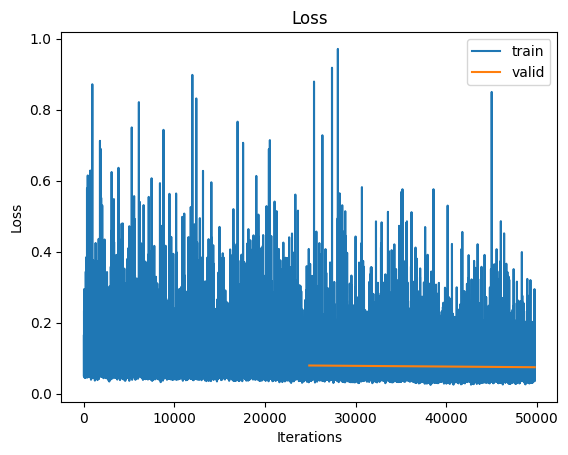

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list_1), label="train")
plt.plot(*zip(*eval_loss_list_1), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

###Train partition 3
Load checkpoint and resume training

In [19]:
simulator = LearnedSimulator()
simulator = simulator.cuda()
checkpoint = torch.load("/content/drive/MyDrive/Dissertation/learning_to_simulate/models/WaterDropFull_15th/checkpoint_99500.pt")
simulator.load_state_dict(checkpoint["model"])

train_dataset_2 = OneStepDataset(data_path_partitioned, "train_600", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path_partitioned, "valid_30", noise_std=params["noise"])

train_loader_2 = dgl.dataloading.GraphDataLoader(train_dataset_2, batch_size=params["batch_size"], pin_memory=True, shuffle=True, drop_last=False, num_workers=2)
valid_loader = dgl.dataloading.GraphDataLoader(valid_dataset, batch_size=params["batch_size"], pin_memory=True, shuffle=False, drop_last=False, num_workers=2)
valid_rollout_dataset = RolloutDataset(data_path_partitioned, "valid_30")

# train the model
train_loss_list_2, eval_loss_list_2, onestep_mse_list_2, rollout_mse_list_2 = train(params, simulator, train_loader_2, valid_loader, valid_rollout_dataset, checkpoint, 2)

Epoch 0:  50%|█████     | 24875/49750 [2:30:54<2990:32:36, 432.80s/it, loss=0.0806, avg_loss=0.0709, lr=9.44e-5]


Eval: Loss: 0.06739314897084474, One Step MSE: 1.2851874063159982e-08


Epoch 0: 100%|██████████| 49750/49750 [5:01:33<00:00, 431.54s/it, loss=0.0394, avg_loss=0.0675, lr=9.34e-5]


Eval: Loss: 0.058586296921816314, One Step MSE: 1.1168473343343195e-08


Epoch 0: 100%|██████████| 49750/49750 [5:01:33<00:00,  2.75it/s, loss=0.0394, avg_loss=0.0675, lr=9.34e-5] 


####Loss plot

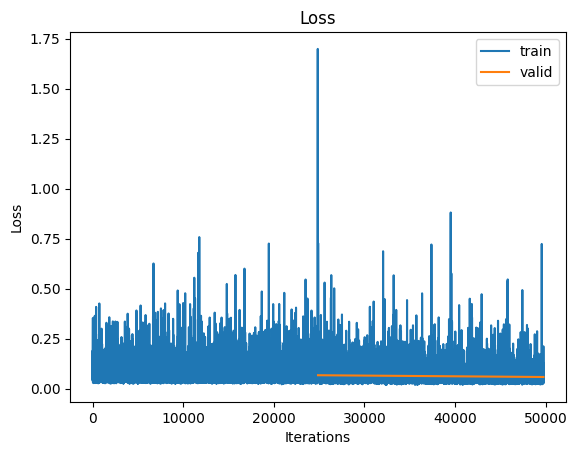

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list_2), label="train")
plt.plot(*zip(*eval_loss_list_2), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

###Train partition 4
Load checkpoint and resume training

In [ ]:
simulator = LearnedSimulator()
simulator = simulator.cuda()
checkpoint = torch.load("/content/drive/MyDrive/Dissertation/learning_to_simulate/models/WaterDropFull_15th/checkpoint_149250.pt")
simulator.load_state_dict(checkpoint["model"])

train_dataset_3 = OneStepDataset(data_path_partitioned, "train_800", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path_partitioned, "valid_30", noise_std=params["noise"])

train_loader_3 = dgl.dataloading.GraphDataLoader(train_dataset_3, batch_size=params["batch_size"], pin_memory=True, shuffle=True, drop_last=False, num_workers=2)
valid_loader = dgl.dataloading.GraphDataLoader(valid_dataset, batch_size=params["batch_size"], pin_memory=True, shuffle=False, drop_last=False, num_workers=2)
valid_rollout_dataset = RolloutDataset(data_path_partitioned, "valid_30")

# train the model
train_loss_list_3, eval_loss_list_3, onestep_mse_list_3, rollout_mse_list_3 = train(params, simulator, train_loader_3, valid_loader, valid_rollout_dataset, checkpoint, 3)

Epoch 0:  50%|█████     | 24875/49750 [2:36:22<3092:12:27, 447.52s/it, loss=0.0325, avg_loss=0.0592, lr=9.23e-5]


Eval: Loss: 0.05268475168018846, One Step MSE: 1.0049072096642698e-08


Epoch 0:  60%|██████    | 29888/49750 [3:02:43<1:47:32,  3.08it/s, loss=0.113, avg_loss=0.0587, lr=9.21e-5]

####Loss plot

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list_3), label="train")
plt.plot(*zip(*eval_loss_list_3), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

###Train partition 5
Load checkpoint and resume training

In [23]:
simulator = LearnedSimulator()
simulator = simulator.cuda()
checkpoint = torch.load("/content/drive/MyDrive/Dissertation/learning_to_simulate/models/WaterDropFull_15th/checkpoint_199000.pt")
simulator.load_state_dict(checkpoint["model"])

train_dataset_4 = OneStepDataset(data_path_partitioned, "train_1000", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path_partitioned, "valid_30", noise_std=params["noise"])

train_loader_4 = dgl.dataloading.GraphDataLoader(train_dataset_4, batch_size=params["batch_size"], pin_memory=True, shuffle=True, drop_last=False, num_workers=2)
valid_loader = dgl.dataloading.GraphDataLoader(valid_dataset, batch_size=params["batch_size"], pin_memory=True, shuffle=False, drop_last=False, num_workers=2)
valid_rollout_dataset = RolloutDataset(data_path_partitioned, "valid_30")

# train the model
train_loss_list_4, eval_loss_list_4, onestep_mse_list_4, rollout_mse_list_4 = train(params, simulator, train_loader_4, valid_loader, valid_rollout_dataset, checkpoint, 4)

Epoch 0:  50%|█████     | 24875/49750 [2:28:47<2933:31:43, 424.55s/it, loss=0.0249, avg_loss=0.0506, lr=9.02e-5]


Eval: Loss: 0.04342468266960513, One Step MSE: 8.270941910486483e-09


Epoch 0: 100%|██████████| 49750/49750 [4:58:27<00:00, 429.29s/it, loss=0.0403, avg_loss=0.0491, lr=8.92e-5]


Eval: Loss: 0.04642054084868125, One Step MSE: 8.848057519796657e-09


Epoch 0: 100%|██████████| 49750/49750 [4:58:28<00:00,  2.78it/s, loss=0.0403, avg_loss=0.0491, lr=8.92e-5] 


####Loss plot

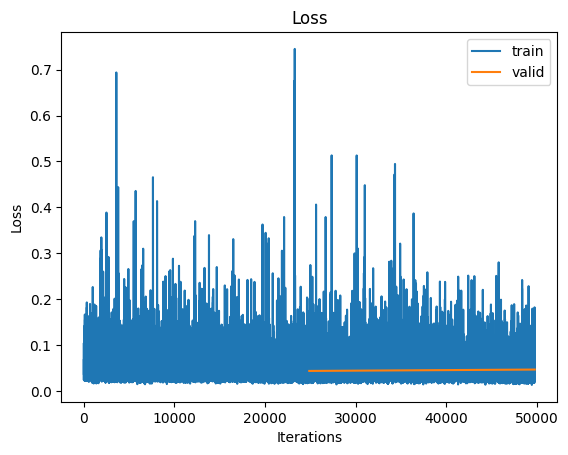

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list_4), label="train")
plt.plot(*zip(*eval_loss_list_4), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

###Generate random rollout to visualize, after training is done

In [ ]:
simulator = LearnedSimulator()
simulator = simulator.cuda()
checkpoint = torch.load("/content/drive/MyDrive/Dissertation/learning_to_simulate/models/WaterDropFull_15th/checkpoint_248750.pt")
simulator.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [25]:
rollout_dataset = RolloutDataset(data_path_partitioned, "test_30")
simulator.eval()
rollout_data = rollout_dataset[0]
rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, params["noise"])
rollout_out = rollout_out.permute(1, 0, 2)

In [38]:
rollout_data = rollout_dataset[10]
rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, params["noise"])
rollout_out = rollout_out.permute(1, 0, 2)

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []
        for _, position, points in plot_info:
            for type_, line in points.items():
                mask = particle_type == type_
                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])
            outputs.append(line)
        return outputs

    return animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.size(0)), interval=10, blit=True)

anim = visualize_pair(rollout_data["particle_type"], rollout_out, rollout_data["position"], rollout_dataset.metadata)
HTML(anim.to_html5_video())